In [1]:
import numpy as np
import pandas as pd
import time
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
#(Q1) We are going to import our tweets dataset as below
start_time = time.time()
tweets_us_df = pd.read_csv(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\us_tweets_sample.csv")
#We drop duplicates based on status id
tweets_us_df.drop_duplicates(subset = ['status_id'])
#Now we take a sample[l]
tweets_us_df = tweets_us_df.sample(n = 500000,random_state = 42)
#However, we already have a state column in our dataset, so let us drop any elements that do not have an entry in the state column
#We are going to first import the Us state dataset
us_df = pd.read_excel(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\us_states.xlsx")
#We need to make all the states in US_df lowercase
for ind, row in us_df.iterrows():
    row['state'] = row['state'].lower()
#We filter it out using the following loop
for ind, row in tweets_us_df.iterrows():
    stat_arr = row['state'].split(",")
    if len(stat_arr) != 1:
        tweets_us_df.drop(row)
#We calculate the values we have
new_len = len(tweets_us_df)
per_drop = (1 -new_len/500000)*100
elapsed_time = time.time() - start_time
print(elapsed_time)
print(new_len,per_drop)
#The run time was 61.92146134376526 second

61.3206262588501
500000 0.0


In [3]:
#(Q2) 
start_time = time.time()
#We already have a state column, so that isn't necessary. However, we do need to add a date column and a region column. 
#Let us start with the region column. We can use the state column to help us out
regions = []
dates = []

for ind, row in tweets_us_df.iterrows():
    #We take the state from each row
    state = row['state']
    #We also use the split method to extract the date from each created at
    date_array = row['created_at'].split(" ")
    dates.append(date_array[0])
    # We find the corresponding row in us_df where the 'state' matches
    row_us = us_df[us_df['state'] == state]

    # we check if a matching row was found
    if not row_us.empty:
        region = row_us['region'].values[0]  # We access the 'region' value in the matching row
        regions.append(region)
    else:
        regions.append('Unknown')  #We handle cases where no matching state is found

tweets_us_df['region'] = regions
tweets_us_df['date'] = dates

elapsed_time = time.time() - start_time
print(elapsed_time)
#The run time was 189 seconds

189.1208803653717


In [4]:
#(Q3) We are going to write a function called tweet cleaner to clean up the text
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords,wordnet
stoppers = stopwords.words('english')
def tweet_cleaner (tweet):
    #We first convert to lower case
    tweet = tweet.lower()
    #Then we look at the first two characters
    substring = tweet[:2]
    #Then we remove all punctutation
    tweet  = re.sub(r'[^\w\s]', '', tweet)
    if(substring == "'b"):
        tweet = tweet[2:]
    tweet_array = tweet.split(" ")
    string = ""
    for word in tweet_array:
        if len(word) <= 3 or word in stoppers or "http" in word or "//" in word or "#" in word:
            tweet_array.remove(word)
        else:
            string = string + " " + word
    return string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssbn0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ssbn0\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssbn0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#(Q4) We now use Lemmitize.py


lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

In [6]:
#(Q4) We insitiate our variable that will contain our cleaned text values
start_time = time.time()
text_clean = []
for ind,row in tweets_us_df.iterrows():
    text_clean.append(lemmatize_tweet(row['text']))
tweets_us_df['text_clean'] = text_clean
elapsed_time = time.time() - start_time
print(elapsed_time)
#The run time was 737 seconds

737.1090114116669


In [7]:
#(Q5 setup) We first will import our dictionaries

import math
import re
from collections import Counter

WORD = re.compile(r"\w+")
vaccine_df = pd.read_excel(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\vaccine_words.xlsx")
isolation_df = pd.read_excel(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\isolation_words.xlsx")
medicine_df = pd.read_excel(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\medicine_words.xlsx")
disinfectant_df = pd.read_excel(r"C:\Users\ssbn0\Downloads\Data Mining\Covid_lab\CSV\disinfectant_words.xlsx")

#We will now have cosine.py



def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)
    
##Example
##cosine_score = get_cosine(text_to_vector(clean_tweet), text_to_vector(" ".join(topic_words)))
##topic_words is a list of words; clean_tweet is a string

#We make a normalizer function
def normalizer(maxi,mini,val):
    #We calculate a function
    rang = maxi - mini
    return (val - mini)/rang 

In [8]:
#(Q5) We will now do the process on every clean tweet
start_time = time.time()
vaccine_counter = Counter(vaccine_df['words'].str.lower())
isolation_counter = Counter(isolation_df['words'].str.lower())
medicine_counter = Counter(medicine_df['words'].str.lower())
disinfectant_counter = Counter(disinfectant_df['words'].str.lower())
#We initialize the arrays
vaccine_cosine = []
isolation_cosine = []
medicine_cosine = []
disinfectant_cosine = []
#We have appended
for index,rows in tweets_us_df.iterrows():
    #We turn the clean tweet into a word vector so we can compare it
    word_vector = text_to_vector(rows['text_clean'])
    #We then compare it and append
    vaccine_cosine.append(get_cosine(vaccine_counter,word_vector))
    isolation_cosine.append(get_cosine(isolation_counter,word_vector))
    medicine_cosine.append(get_cosine(medicine_counter,word_vector))
    disinfectant_cosine.append(get_cosine(disinfectant_counter,word_vector))
#We create our new columns
tweets_us_df['vaccine_cosine'] = vaccine_cosine
tweets_us_df['isolation_cosine'] = isolation_cosine
tweets_us_df['medicine_cosine'] = medicine_cosine
tweets_us_df['disinfectant_cosine'] = disinfectant_cosine
#We now get maximums and minimums so we can normalize
maxi = max(max(vaccine_cosine),max(isolation_cosine),max(medicine_cosine),max(disinfectant_cosine))
mini = min(min(vaccine_cosine),min(isolation_cosine),min(medicine_cosine),min(disinfectant_cosine))
#We initialize the arrays for the normalized columns
vaccine_cosine_norm = []
isolation_cosine_norm = []
medicine_cosine_norm = []
disinfectant_cosine_norm = []
#Here we will normalize the rows using our normalizing function we wrote above
for index,rows in tweets_us_df.iterrows():
    vaccine_cosine_norm.append(normalizer(maxi,mini,rows['vaccine_cosine']))
    isolation_cosine_norm.append(normalizer(maxi,mini,rows['isolation_cosine']))
    medicine_cosine_norm.append(normalizer(maxi,mini,rows['medicine_cosine']))
    disinfectant_cosine_norm.append(normalizer(maxi,mini,rows['disinfectant_cosine']))

tweets_us_df['vaccine_cosine_normal'] = vaccine_cosine_norm
tweets_us_df['isolation_cosine_normal'] = isolation_cosine_norm
tweets_us_df['medicine_cosine_normal'] = medicine_cosine_norm
tweets_us_df['disinfectant_cosine_normal'] = disinfectant_cosine_norm

elapsed_time = time.time() - start_time
print(elapsed_time)
#The run time was 16855 seconds

16855.25216794014


In [9]:
#(Q6) We are going to use subdataframes. Let us do the regions first. Let us initialize the dataframe.
start_time = time.time()
columns = ['Region', 'Avg_Isolation_Score','Avg_Vaccine_Score','Avg_Medicine_Score','Avg_Disinfectant_Score']
region_topic_score = pd.DataFrame(columns=columns)
regions = ["Northeast","South","West","Midwest"]
#We intitiate the columns to get started
r_avg_norm_isolation = []
r_avg_norm_vaccine = []
r_avg_norm_medicine = []
r_avg_norm_disinfectant = []
#We Create our subgroups
grouped = tweets_us_df.groupby('region')
#We then iterate through the regions
for reg in regions:
    #We then append the isolation
    r_avg_norm_isolation.append(grouped.get_group(reg)['isolation_cosine_normal'].mean())
    r_avg_norm_vaccine.append(grouped.get_group(reg)['vaccine_cosine_normal'].mean())
    r_avg_norm_medicine.append(grouped.get_group(reg)['medicine_cosine_normal'].mean())
    r_avg_norm_disinfectant.append(grouped.get_group(reg)['disinfectant_cosine_normal'].mean())
#We then add the columns
region_topic_score['Region'] = regions
region_topic_score['Avg_Isolation_Score'] = r_avg_norm_isolation
region_topic_score['Avg_Vaccine_Score'] = r_avg_norm_vaccine
region_topic_score['Avg_Medicine_Score'] = r_avg_norm_medicine
region_topic_score['Avg_Disinfectant_Score'] = r_avg_norm_disinfectant
#We repeat this process for the state datasheet
columns = ['State', 'Avg_Isolation_Score','Avg_Vaccine_Score','Avg_Medicine_Score','Avg_Disinfectant_Score']
state_topic_score = pd.DataFrame(columns=columns)
states = us_df['state'].tolist()
#We intitiate the columns to get started
s_avg_norm_isolation = []
s_avg_norm_vaccine = []
s_avg_norm_medicine = []
s_avg_norm_disinfectant = []
#We Create our subgroups
grouped1 = tweets_us_df.groupby('state')
#We then iterate through the regions
for state in states:
    #We then append the mean scores to our column array. There are no tweets from west virginia, so I handled that exception
    if state != 'west virginia':
        s_avg_norm_isolation.append(grouped1.get_group(state)['isolation_cosine_normal'].mean())
        s_avg_norm_vaccine.append(grouped1.get_group(state)['vaccine_cosine_normal'].mean())
        s_avg_norm_medicine.append(grouped1.get_group(state)['medicine_cosine_normal'].mean())
        s_avg_norm_disinfectant.append(grouped1.get_group(state)['disinfectant_cosine_normal'].mean())
    else:
        s_avg_norm_isolation.append(0)
        s_avg_norm_vaccine.append(0)
        s_avg_norm_medicine.append(0)
        s_avg_norm_disinfectant.append(0)
#We then add the columns
state_topic_score['State'] = states
state_topic_score['Avg_Isolation_Score'] = s_avg_norm_isolation
state_topic_score['Avg_Vaccine_Score'] = s_avg_norm_vaccine
state_topic_score['Avg_Medicine_Score'] = s_avg_norm_medicine
state_topic_score['Avg_Disinfectant_Score'] = s_avg_norm_disinfectant
elapsed_time = time.time() - start_time
print(elapsed_time)
#The run time was 6.13 seconds

6.13823938369751


In [1]:

# (Q7) We first drop our state column so we can enter it as a numeric matrix
state_topic_num = state_topic_score[['Avg_Isolation_Score','Avg_Vaccine_Score','Avg_Medicine_Score','Avg_Disinfectant_Score']]

# K-Means clustering
kmeans = sklearn.cluster.KMeans(n_clusters=4, init = 'k-means++', random_state=0, n_init=10).fit(state_topic_num)
kmeans_labels = kmeans.labels_

# Spectral Clustering
spec = sklearn.cluster.SpectralClustering(n_clusters=4, random_state=0, n_init=10).fit(state_topic_num)
spec_labels = spec.labels_

# Assign the cluster labels back to the DataFrame
state_topic_score['KMeans_Labels'] = kmeans_labels
state_topic_score['Spectral_Labels'] = spec_labels

NameError: name 'state_topic_score' is not defined

In [48]:
#(Q8) We now are going to use CH score to find optimal number of clusters# Define the range of cluster numbers you want to consider
cluster_numbers = range(2, 21)  # You can adjust this range

# Initialize an empty list to store CH scores
ch_scores_kmeans = []
ch_scores_spectral = []
for n_clus in cluster_numbers:

    kmeans = sklearn.cluster.KMeans(n_clusters=n_clus, init = 'k-means++', random_state=0, n_init=10).fit(state_topic_num)
    kmeans_labels = kmeans.labels_
    
    spec = sklearn.cluster.SpectralClustering(n_clusters=n_clus, random_state=0, n_init=10).fit(state_topic_num)
    spec_labels = spec.labels_

    # Compute the CH score for the current number of clusters
    ch_score_kmeans = sklearn.metrics.calinski_harabasz_score(state_topic_num, kmeans_labels)
    ch_score_spectral = sklearn.metrics.calinski_harabasz_score(state_topic_num, spec_labels)
    
    # Append the CH score to the list
    ch_scores_kmeans.append(ch_score_kmeans)
    ch_scores_spectral.append(ch_score_spectral)

# Find the number of clusters with the highest CH score
optimal_n_clusters_kmeans = cluster_numbers[ch_scores_kmeans.index(max(ch_scores_kmeans))]
optimal_n_clusters_spectral = cluster_numbers[ch_scores_spectral.index(max(ch_scores_spectral))]
print(optimal_n_clusters_kmeans, optimal_n_clusters_spectral)

C:\Users\ssbn0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ssbn0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ssbn0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ssbn0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

20 2


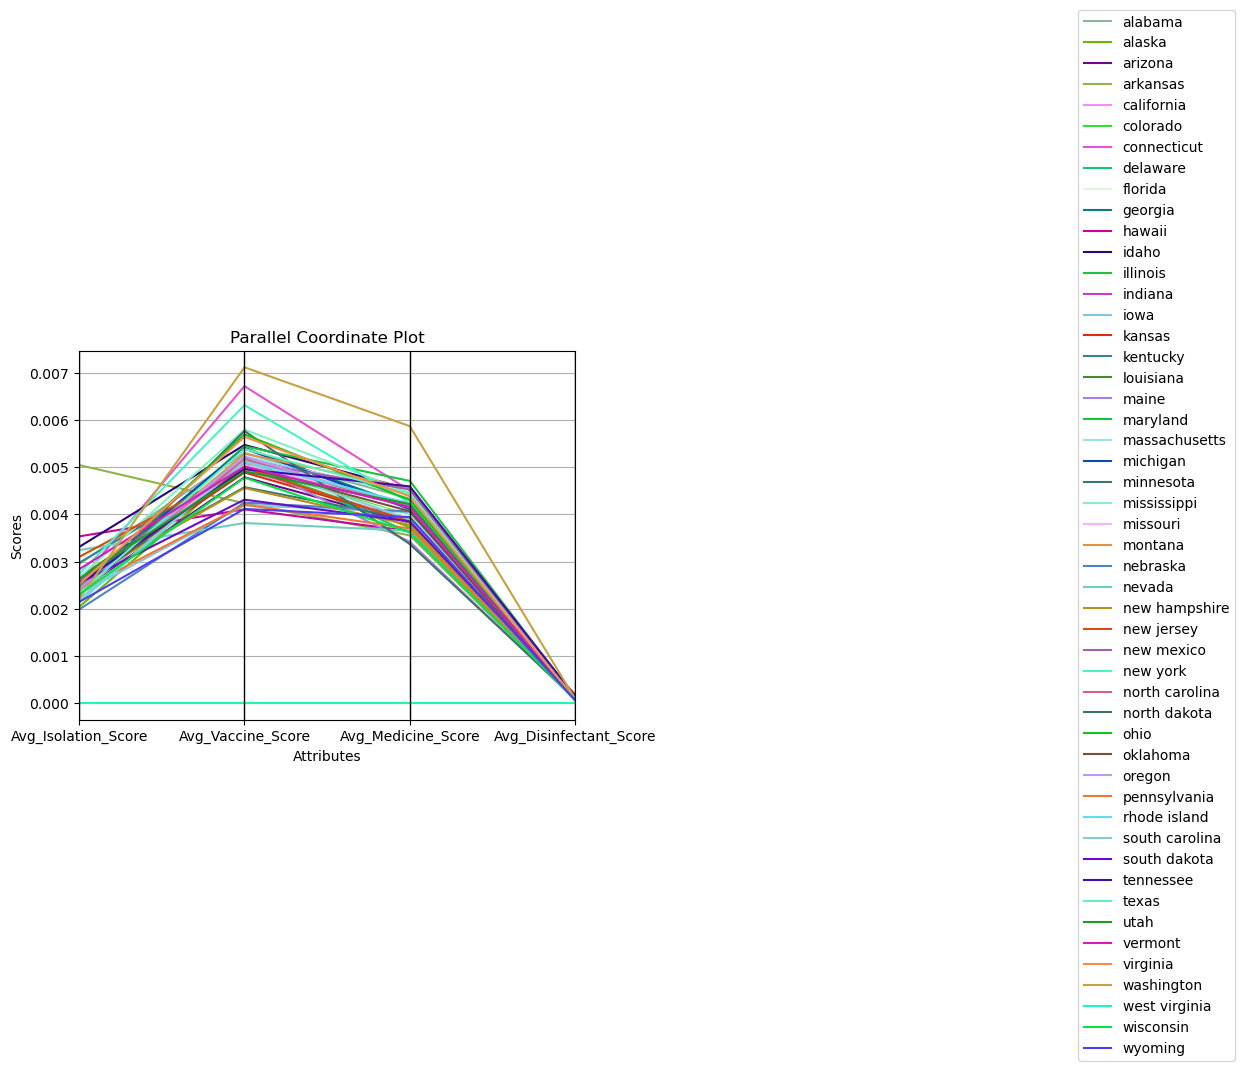

In [50]:
#(Q9) Here we are going to plot parallel
plt.figure()

pd.plotting.parallel_coordinates(
    state_topic_score[['State','Avg_Isolation_Score','Avg_Vaccine_Score','Avg_Medicine_Score','Avg_Disinfectant_Score']],'State')

plt.legend(loc='center left', bbox_to_anchor=(2, 0.5))

plt.title('Parallel Coordinate Plot')
plt.xlabel('Attributes')
plt.ylabel('Scores')

plt.show()

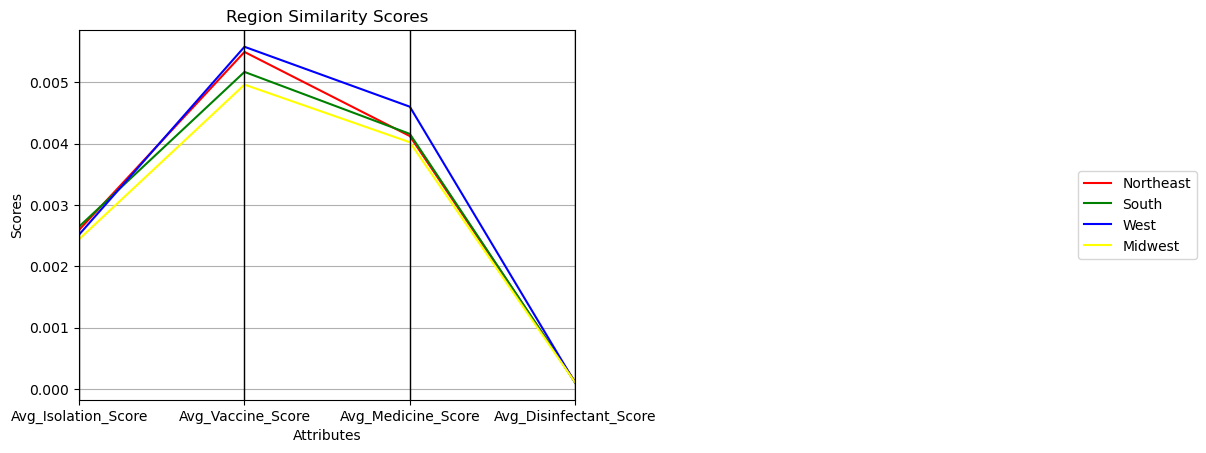

In [55]:
#(Q10) Here we are going to plot parallel for Regions
plt.figure()

pd.plotting.parallel_coordinates(
    region_topic_score[['Region','Avg_Isolation_Score','Avg_Vaccine_Score','Avg_Medicine_Score','Avg_Disinfectant_Score']],'Region',
color=['red', 'green', 'blue', 'yellow'])

plt.legend(loc='center left', bbox_to_anchor=(2, 0.5))

plt.title('Region Similarity Scores')
plt.xlabel('Attributes')
plt.ylabel('Scores')

plt.show()

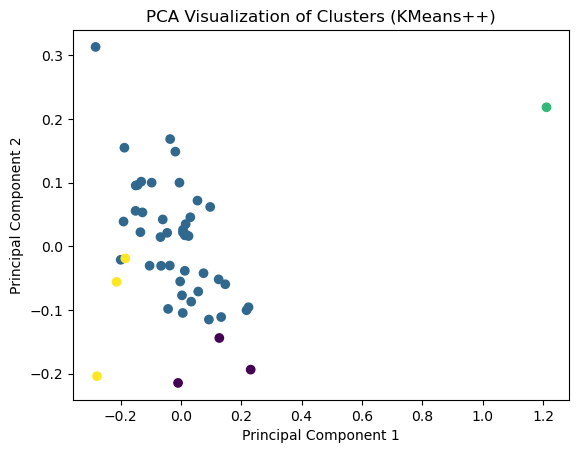

In [58]:
#(Q11) Here we are going to use PCA dimensionality reduction


#We create a PCA instance with the desired number of components
pca = PCA(n_components=2)  # You can choose 2 or 3 components for visualization

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(state_topic_num)
#We fit and transform the data
states_pca = pca.fit_transform(data_normalized)
#We create a scatter plot of the PCA results
plt.scatter(states_pca[:,0], states_pca[:,1], c = state_topic_score['KMeans_Labels'], cmap='viridis')
#labels = state_topic_score['State']
#for i, label in enumerate(labels):
    #plt.annotate(label, (states_pca[i,0], states_pca[i,1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters (KMeans++)')
plt.show()

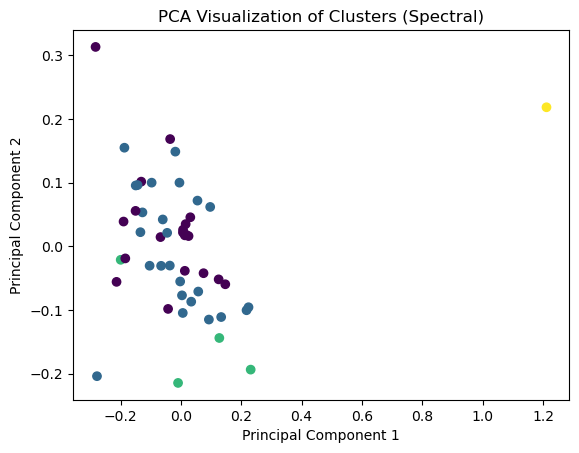

In [57]:
#(Q11) Here we are going to use PCA dimensionality reduction


#We create a PCA instance with the desired number of components
pca = PCA(n_components=2)  # You can choose 2 or 3 components for visualization

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(state_topic_num)
#We fit and transform the data
states_pca = pca.fit_transform(data_normalized)
#We create a scatter plot of the PCA results
plt.scatter(states_pca[:,0], states_pca[:,1], c = state_topic_score['Spectral_Labels'], cmap='viridis')
#labels = state_topic_score['State']
#for i, label in enumerate(labels):
    #plt.annotate(label, (states_pca[i,0], states_pca[i,1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters (Spectral)')
plt.show()

In [28]:
state_topic_score

,State,Avg_Isolation_Score,Avg_Vaccine_Score,Avg_Medicine_Score,Avg_Disinfectant_Score,KMeans_Labels,Spectral_Labels
0,alabama,0.002948,0.005303,0.004331,0.000113,2,0
1,alaska,0.002041,0.005056,0.003727,0.000131,1,3
2,arizona,0.002380,0.004786,0.003826,0.000107,1,3
3,arkansas,0.005045,0.004236,0.003555,0.000090,0,2
4,california,0.002525,0.004944,0.003882,0.000107,1,3
5,colorado,0.002666,0.005026,0.003979,0.000097,1,3
6,connecticut,0.002570,0.006716,0.004505,0.000115,3,1
7,delaware,0.002437,0.005191,0.003614,0.000107,1,3
8,florida,0.002384,0.004979,0.003965,0.000104,1,3
9,georgia,0.002460,0.005412,0.004156,0.000133,1,3


In [72]:
state_topic_score[state_topic_score['Spectral_Labels'] == 0]

,State,Avg_Isolation_Score,Avg_Vaccine_Score,Avg_Medicine_Score,Avg_Disinfectant_Score,KMeans_Labels,Spectral_Labels
1,alaska,0.002041,0.005056,0.003727,0.000131,1,0
2,arizona,0.002380,0.004786,0.003826,0.000107,1,0
4,california,0.002525,0.004944,0.003882,0.000107,1,0
5,colorado,0.002666,0.005026,0.003979,0.000097,1,0
6,connecticut,0.002570,0.006716,0.004505,0.000115,3,0
7,delaware,0.002437,0.005191,0.003614,0.000107,1,0
8,florida,0.002384,0.004979,0.003965,0.000104,1,0
9,georgia,0.002460,0.005412,0.004156,0.000133,1,0
12,illinois,0.002392,0.005026,0.003830,0.000103,1,0
15,kansas,0.002526,0.004888,0.003868,0.000105,1,0


In [54]:
region_topic_score

,Region,Avg_Isolation_Score,Avg_Vaccine_Score,Avg_Medicine_Score,Avg_Disinfectant_Score
0,Northeast,0.002593,0.005494,0.004122,0.000117
1,South,0.002647,0.005168,0.004158,0.000106
2,West,0.002517,0.005578,0.004601,0.000101
3,Midwest,0.002442,0.004961,0.004022,0.000105
